# 1-k-Means-Clustering

Follow the notebook to understand the background and implementation of k-means clustering using built-in libraries and functions followed by a visualization of their associated graphs and analysis of their accuracy.

First, we need to setup the dependencies and import the dataset.

In [1]:
#import the libraries and classes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

## Background/Basic Demonstration

First, we will create some artificial data to better understand how the k-mean clustering works.

We create a random set of numbers with size 300 x 4 and plot the input.

In [29]:
from sklearn.datasets import make_blobs
n_k = 4
center = 5
X, y = make_blobs(n_samples = 300, n_features = n_k, centers = center, cluster_std = 2.5, random_state = 42)

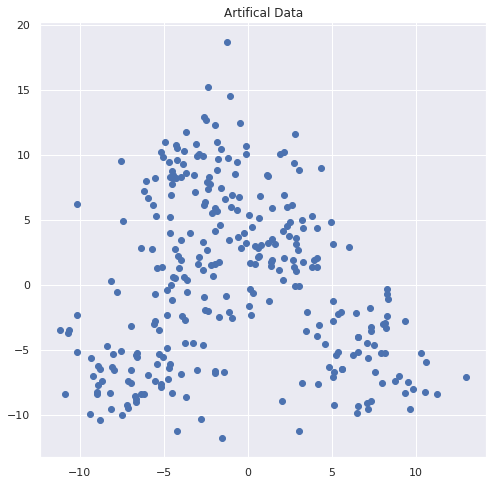

In [3]:
plt.figure(figsize = (8, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.title('Artifical Data')
plt.show()

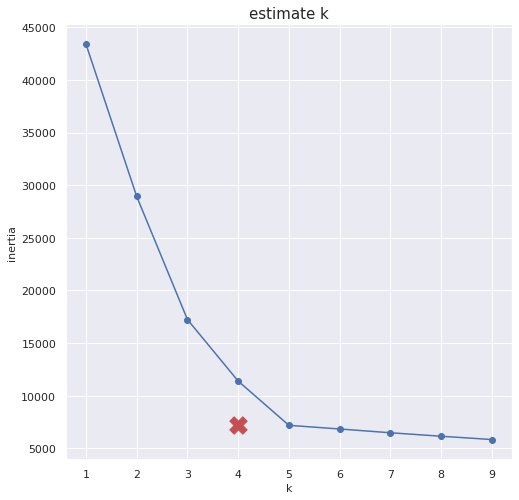

In [30]:
#tip: using pca and getting the data to one dimension can help give an indicator of what k is
#the following is the heuristic approach
from sklearn.cluster import KMeans

inertia_list = []
for k in range(1, 10):
  model = KMeans(n_clusters = k, init = "k-means++")
  model.fit(X)
  inertia_list.append(model.inertia_) #inertia_ = attribute

#estimate where the ideal k is
plt.figure(figsize = (8,8))
plt.plot(range(1,10), inertia_list, label = None)
plt.scatter(range(1,10), inertia_list)
plt.scatter(n_k, inertia_list[n_k], marker ="X", s=300, c= "r")
plt.xlabel("k", fontsize=11)
plt.ylabel("inertia", fontsize=11)
plt.title('estimate k', fontsize=15)
plt.show()

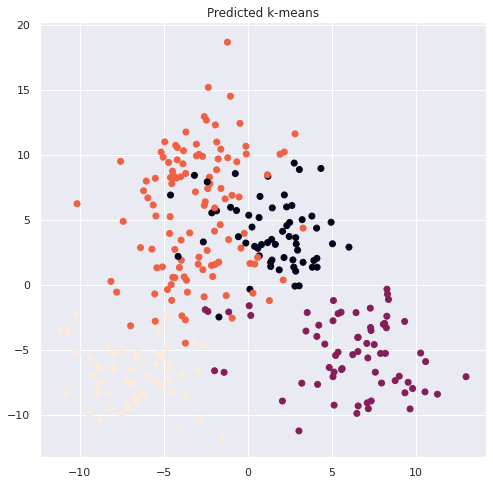

In [31]:
#predict k-means using skLearn
kmeans = KMeans(n_clusters=n_k, init="k-means++")
kmeans.fit(X)

y_predict = kmeans.predict(X)

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_predict)
plt.title('Predicted k-means')
plt.show()

Knowing the seperation of the data based on k-means, we now want to find the center of the clusters using functions written from scratch

In [32]:
def create_centroids(k, inputs): #create an initial guess
  centroids = inputs.sample(k)
  return centroids

def error(a, b): #calculate the error on the guess
  return np.square(np.sum((a-b)**2))

def assign_centroid(inputs, cent): #assign an updated guess
  k = cent.shape[0]
  n = inputs.shape[0]
  assign = []; assign_err = []

  for obj in range(n):
    all_err = []
    for centroid in range(k):
        err = error(cent.iloc[centroid,:], inputs.iloc[obj,:])
        all_err.append(err)
    
    closest_cent = np.where(all_err==np.amin(all_err))[0].tolist()[0]
    closest_cent_err = np.amin(all_err)

    assign.append(closest_cent)
    assign_err.append(closest_cent_err)

  return assign

In [39]:
blob_df = pd.DataFrame()
blob_df['x'] = X[:, 0]
blob_df['y'] = X[:, 1]

#make an initial guess
get_centroid = create_centroids(n_k, blob_df)

#append the initial guess to the dataframe
blob_df['centroid'] = assign_centroid(blob_df, get_centroid) 

In [40]:
#initial guess
get_centroid

,x,y
285,1.350079,1.395137
66,0.071108,-1.622275
1,-6.047624,7.962673
96,-5.512560,-2.812596


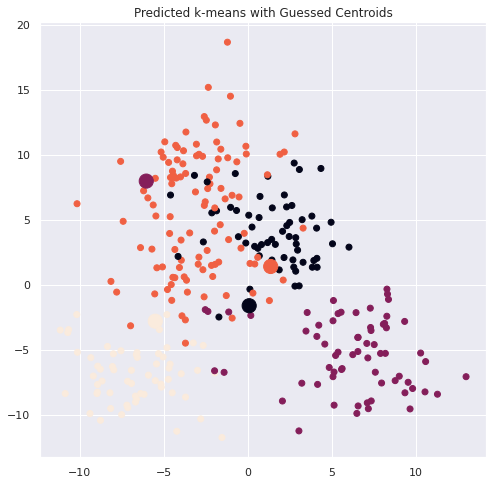

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_predict)
plt.scatter(get_centroid.x, get_centroid.y, s=200, c=pd.unique(y_predict))
plt.title('Predicted k-means with Guessed Centroids')
plt.show()

We can see that the coloring for the centroids is inaccurate for most of the blobs and need to recalculate to make a better estimated guess

In [42]:
colnames = list(blob_df.columns[0:-1])
get_centroid = blob_df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)

In [43]:
get_centroid

,x,y
0,2.256639,2.811035
1,4.933629,-5.204302
2,-3.211824,8.575290
3,-6.178788,-5.243030


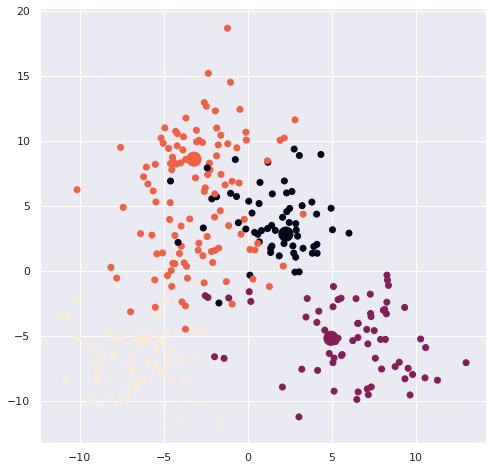

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_predict)
plt.scatter(get_centroid.x, get_centroid.y, s=200, c=np.unique(y_predict))
plt.show()

We can see that most times, 3/4 centers find their correct location, meaning that the 1/4 times has some slight miscalculation but nonetheless shows the distinct clusters as specified

## Implementation with Real Data

To test clustering on a real-world example, we use try to cluster colors on an image

### Pre-Process 

Before implementing the algorithm, we want to examine our input image to see whether any pre-processing needs to occur. Here, we use an image of the Rice Quad that has a pixel size of 1080x720. We will likely need to scale this down to a max of 255 since that is the basis for RGB color values.

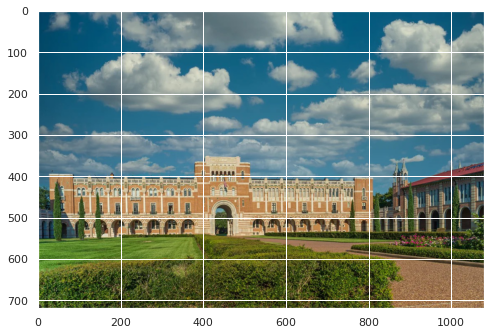

In [13]:
from matplotlib.image import imread
image = imread("rice.jpeg")

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

In [14]:
#shrink the size of the image to a max of 255
pixels=np.array(image)
pixels = pixels.astype('float32')
pixels/=255.0

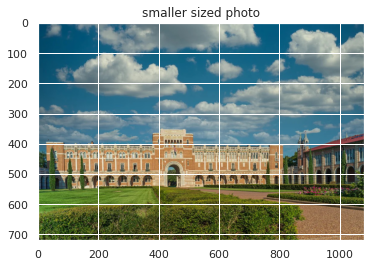

In [15]:
#plt.figure(figsize=(8,8))
#scale is wrong?
plt.imshow(pixels)
plt.title('smaller sized photo')
plt.show()

### k-mean Implementation

Here we use the skLearn KMeans used in the previous example. Here we choose k to be 3, but can be changed to run almost any value within reason

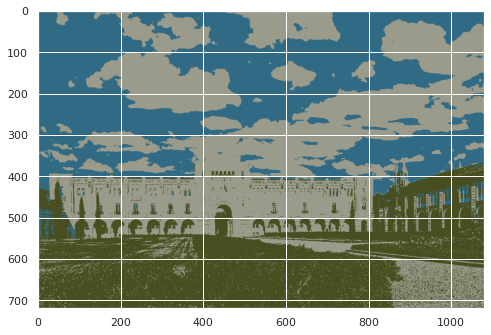

In [16]:
X = pixels.reshape(-1, 3)
k = 3
kmeans = KMeans(n_clusters=k).fit(X)
new_image = kmeans.cluster_centers_[kmeans.labels_]
new_image = new_image.reshape(image.shape)

plt.figure(figsize=(8,8))
plt.imshow(new_image)
plt.show()

The output image seperates the image into the 3 distinct color sections, blue, white(or tan?), and green. Next, we want to train the model and calculate the accuracy of the outputs

### Testing and Analysis

Using a synthetic dataset called load_digits from SkLearn, we can calculate the accuracy of the KMeans function we have been using

In [17]:
#load the artifical data
from sklearn.datasets import load_digits
from sklearn import preprocessing
X, y = load_digits(return_X_y = True)

In [18]:
X.shape

(1797, 64)

In [19]:
#split input data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

scaling = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaling.transform(X_train)

In [20]:
X_scaled.shape

(1347, 64)

In [21]:
#calculate the regression on training set
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2000)
clf.fit(X_scaled, y_train)

#accuracy of the Logistic Regression on its own
print(f"{clf.score(X_test, y_test)}")

0.8244444444444444


In [22]:
from sklearn.pipeline import Pipeline

#use SkLearn to calculate the accuracy of Logistic regression when using k means first
pipeline = Pipeline([("kmeans", KMeans(n_clusters = 10)),
                     ("logistric_regression", LogisticRegression(max_iter=2000))])

pipeline.fit(X_train, y_train)
print(f"{pipeline.score(X_test, y_test)}")

0.9133333333333333


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see there is a 10% increase in accuracy after partitioning the training values by kmeans before passing through the regression model